# Language Understang System - midterm project

## University of Trento - A.Y. 2019 / 2020


Davide Zanella - 211463

----
The full code can be found on github: https://github.com/davidezanella/NLP-concept-tagging

**Warning**: The execution of the whole Notebook will take a lot of hours or maybe days to complete.

---

Firstly, let's import some necessary libraries and define some useful methods. They will be used later on to execute some shell commands, manage corpus and Conll files, compute the frequency of the tokens of the dataset and apply the cut-off on them.

In [1]:
# to import conll
import os
import subprocess
import sys
sys.path.insert(0, os.path.abspath('./src/'))

from conll import evaluate

import pandas as pd

from tqdm.notebook import tqdm

In [2]:
def execute(cmd):
    """
    execute a shell command
    :param cmd: command to be executed
    :return: standard output
    """
    return subprocess.check_output(cmd, shell=True).decode(sys.stdout.encoding)

In [3]:
def get_column(corpus, column=-1):
    """
    return a column from a corpus
    :param corpus: corpus elements
    :param column: column index
    :return: the specified column
    """
    return [[word[column] for word in sent] for sent in corpus]

In [4]:
# modified version to support fst-output
def read_fst4conll(fst_file, fs="\t", oov='<unk>', otag='O', sep='+', split=False):
    """
    :param corpus_file: corpus in conll format
    :param fs: field separator
    :param oov: token to map to otag (we need to get rid of <unk> in labels)
    :param otag: otag symbol
    :param sep: 
    :param split:
    :return: corpus 
    """
    sents = []  # list to hold words list sequences
    words = []  # list to hold feature tuples

    for line in open(temp_folder + fst_file):
        line = line.strip()
        if len(line.strip()) > 0:
            feats = tuple(line.strip().split(fs))
            # arc has minimum 3 columns, else final state
            if len(feats) >= 3:
                ist = feats[2]  # 3rd column (input)
                ost = feats[3]  # 4th column (output)
                # replace '<unk>' with 'O'
                ost = otag if ost == oov else ost
                # ignore for now
                ost = ost.split(sep)[1] if split and ost != otag else ost
                
                words.append((ist, ost))
            else:
                sents.append(words)
                words = []
        else:
            if len(words) > 0:
                sents.append(words) 
                words = []
    return sents

In [5]:
def read_corpus_conll(corpus_file, fs="\t"):
    """
    read corpus in CoNLL format
    :param corpus_file: corpus in conll format
    :param fs: field separator
    :return: corpus
    """
    featn = None  # number of features for consistency check
    sents = []  # list to hold words list sequences
    words = []  # list to hold feature tuples

    for line in open(corpus_file):
        line = line.strip()
        if len(line.strip()) > 0:
            feats = tuple(line.strip().split(fs))
            if not featn:
                featn = len(feats)
            elif featn != len(feats) and len(feats) != 0:
                raise ValueError("Unexpected number of columns {} ({})".format(len(feats), featn))

            words.append(feats)
        else:
            if len(words) > 0:
                sents.append(words)
                words = []
    return sents

In [6]:
def compute_frequency_list(corpus):
    """
    create frequency list for a corpus
    :param corpus: corpus as list of lists
    """
    frequencies = {}
    for sent in corpus:
        for token in sent:
            frequencies[token] = frequencies.setdefault(token, 0) + 1
    return frequencies

In [7]:
def cutoff(corpus, tf_min=2):
    """
    apply min cutoffs
    :param tf_min: minimum token frequency for lexicon elements (below removed); default 2
    :return: lexicon as set
    """
    frequencies = compute_frequency_list(corpus)
    return sorted([token for token, frequency in frequencies.items() if frequency >= tf_min])

In order to keep the project's folder clean, some global variables containg the working directories are defined.

In [8]:
temp_folder = 'tmp/'
wdir = temp_folder + 'wdir_wt/'

The transing, testing and POS datasets are copied inside the working directory.

In [9]:
dpath = 'dataset/'

def init():
    """
    create temporary folder and prepare training and testing dataset
    """
    execute('mkdir -p ' + temp_folder)

    execute('cp {}NL2SparQL4NLU.train.utterances.txt {}trn.txt'.format(dpath, temp_folder))
    execute('cp {}NL2SparQL4NLU.test.utterances.txt {}tst.txt'.format(dpath, temp_folder))

    execute('cp {}NL2SparQL4NLU.train.conll.txt {}trn.conll'.format(dpath, temp_folder))
    execute('cp {}NL2SparQL4NLU.test.conll.txt {}tst.conll'.format(dpath, temp_folder))

    execute('cp {}NL2SparQL4NLU.train.features.conll.txt {}pos.tag.conll'.format(dpath, temp_folder))

In [10]:
init()

<center><h2>SCLM functions</h2></center>

To simplify the implementation and make clearer the whole project, it is, by majority, organised in classes.

The first two classes are enumeratives. The first one defines the different baselines of a SCLM, while the second one defines the different smoothing methods that can be used to train a Ngram model.

#TODO: explain different types

In [11]:
from enum import IntEnum, Enum

class Baseline(IntEnum):
    none = 0
    random_path = 1
    output_symbol_priors = 2
    MLE = 3
    

class NgramMethod(Enum):
    katz = 'katz'
    presmoothed = 'presmoothed'
    unsmoothed = 'unsmoothed'
    absolute = 'absolute'
    kneser_ney = 'kneser_ney'
    witten_bell = 'witten_bell'

The following class represents a Symbol file, could be an input or output one. The values of the symbols are stored in a list, but there is a method to load them from a file, save them to a file, compile the symbols in order to use them with an FST or Ngram and a specific method to join a `Symbols` element with another one.

In [12]:
class Symbols:
    def __init__(self, file_name):
        self.file_name = file_name
        self.values = []
        
        self.oov = '<unk>'  # unknown symbol
        self.fs = " "       # wfst specification column separator
        
        
    def load(self):
        """
        load the Symbols from the file associated
        :return:
        """
        with open(temp_folder + self.file_name, 'r') as f:
            self.values = [ l.split('\t')[0] for l in f.readlines() ]
    
    
    def set_symbols(self, values):
        """
        Set the values of the Symbols
        :param values: values
        :return:
        """
        self.values = sorted(list(set(values)))
        
        
    def _get_list_file_name(self):
        """
        return the name of the file containing the list of Symbols
        :return: symbols list file name
        """
        return self.file_name + '.lst'
        
        
    def save_list(self):
        """
        Save the Symbols list in a file
        :return:
        """
        with open(temp_folder + self._get_list_file_name(), 'w+') as f:
            for i in range(len(self.values)):
                f.write('{0}\n'.format(self.values[i]))
                
    
    def compile(self):
        """
        Compile the Symbols
        :return:
        """
        self.save_list()
        execute('ngramsymbols {0}{1} {0}{2}'.format(temp_folder, self._get_list_file_name(), self.file_name))
        
        
    def join_symbols(self, osymbols, file_name):
        """
        Join two Symbols set
        :param osymbols: output Symbols to join with
        :param file_name: file name of the output Symbols
        :return: the created Symbols
        """
        join_symbols = Symbols(file_name + '.syms')
        join_symbols.set_symbols(self.values + osymbols.values)
        join_symbols.compile()        
        
        with open(temp_folder + file_name, 'w') as f:
            for osym in osymbols.values + [self.oov]:
                for isym in self.values + [self.oov]:
                    line = [ osym, isym ]
                    f.write(self.fs.join(line) + "\n")
        
        return join_symbols

The class below represents a Conll, it is associated with a file and can load or save to it its values stored. A Conll should have some input Symbols associated and some output Symbols too. With the following class it's easy to apply a cut-off on the tokens or create a dataset with sentences composed by the output tokens. There are even some more sophisticated methods ready to be used:

- `clone_reversed`: a new Conll class will be created where the input and output symbols are reversed.

    Original: $word \rightarrow token$
   
    Result: $token \rightarrow word$
- `remove_OoS`: in the resulting Conlls the Out-of-Span tags will be removed and substituted by the token and the POS tag. The final tokens that are not the OoS are kept the same in the middle stages.

    Original: $word \rightarrow token$
    
    Result: $word \rightarrow word|POS \rightarrow token$
- `remove_OoS_and_POS`: three new Conlls will be created. The first one adds the POS tag next to the word while the second one tranforms the output of the first Conll to the word followed by the `O` tag or only the final token. The last Conll transforms the previous output to a final token.

    Original: $word \rightarrow token$
    
    Result: $word \rightarrow word|POS \rightarrow word|O \rightarrow token$
- `remove_OoS_POS_norm`: with this function four Conlls are created. The first one transforms words to its lemma followed by the POS tag. The second Conll normalize the word categorizing it using spacy. For example all the persons are grouped by the same tag `PERSON`. The third Conll replace the POS tag with the `O` if it is the case of substitute with the final token. The last Conll transforms the previous output to the final tokens.

    Original: $word \rightarrow token$
    
    Result: $word \rightarrow lemma|POS \rightarrow NORM|POS \rightarrow NORM|O \rightarrow token$

In [13]:
import copy


class Conll:
    def __init__(self, file_name, wt=False):
        self.file_name = file_name
        self.isymbols = None
        self.osymbols = None
        self.sentences = []
        
        self.wt = wt
    
    
    def load(self):
        """
        Load from the Conll file associated
        :return:
        """
        with open(temp_folder + self.file_name, 'r') as f:
            sentences = f.read().split('\n\n')
            sentences = [ l.split('\n') for l in sentences ]
            self.sentences = [ [ w.split('\t') for w in  l ] for l in sentences ]

        self.sentences = list(filter(lambda i : i != [['']], self.sentences))

        self.find_symbols()
        
        return self
    
    
    def save(self):
        """
        Save the Conll to the file associated
        :return:
        """
        with open(temp_folder + self.file_name, 'w+') as f:
            for s in self.sentences:
                for w in s:
                    f.write('{0}\t{1}\n'.format(w[0], w[1]))
                f.write('\n')
        
        return self

        
    def set_isymbols(self, values):
        """
        Set the input Symbols of the Conll
        :param values: values of the input Symbols
        :return:
        """
        self.isymbols = Symbols(self.file_name + '.isyms')
        self.isymbols.set_symbols(list(set(values)))
        self.isymbols.compile()


    def set_osymbols(self, values):
        """
        Set the output Symbols of the Conll
        :param values: values of the output Symbols
        :return:
        """
        self.osymbols = Symbols(self.file_name + '.osyms')
        self.osymbols.set_symbols(list(set(values)))
        self.osymbols.compile()
    
    
    def find_symbols(self):
        """
        retrieve the input and output Symbols from the Conll
        :return:
        """
        isyms = [ w[0] for s in self.sentences for w in s ]
        self.set_isymbols(isyms)
        osyms = [ w[1] for s in self.sentences for w in s ]
        
        if self.wt:
            osyms = [ isyms[i] + '+' + osyms[i] for i in range(len(isyms)) ]

        self.set_osymbols(osyms)
    
    
    def apply_cutoff(self, min_freq):
        """
        Apply cut-off to the Conll based on the mean frequency of the tokens
        :param min_freq: minimum frequency
        :return:
        """
        wt_sents = [[ "+".join(w) for w in s ] for s in self.sentences ]
        wt_cutted_off = cutoff(wt_sents, min_freq)
        
        self.set_isymbols([ w.split('+')[0] for w in wt_cutted_off ])
        
        orig_osyms = [ w.split('+')[1] for w in wt_cutted_off ]
        if self.wt:
            self.set_osymbols(wt_cutted_off)
        else:
            self.set_osymbols(orig_osyms)

        return self
    
    
    def _get_dt_filename(self):
        """
        Get the filename of the dataset associated
        :return:
        """
        return self.file_name + '.dt'
    
    
    def create_dataset(self):
        """
        Create the dataset based on the Conll
        :return: file name of the dataset created
        """
        with open(temp_folder + self._get_dt_filename(), 'w') as f:
            for s in self.sentences:
                if self.wt:
                    line = ' '.join([ w[0] + '+' + w[1] for w in s ])
                else:
                    line = ' '.join([ w[1] for w in s ])
                f.write(line + '\n')
        return self._get_dt_filename()
    
    
    def clone_reversed(self, file_name):
        """
        Create a new Conll where input and output Symbols are reversed
        :param file_name: file name of the reversed Conll
        :return: the reversed Conll
        """
        reverse = Conll(file_name, wt=self.wt)
        
        reverse.isymbols = self.osymbols
        reverse.osymbols = self.isymbols
        reverse.sentences = [ [ list(reversed(w)) for w in s ] for s in self.sentences ]
        
        reverse.save()
        
        return reverse
    
    
    def remove_OoS(self, pos_conll):
        """
        Create two transitionary Conlls without the Out-of-Span tokens.
        "token" -> "token|POS_tag" -> "concept"
        :param pos_conll: Conll with the POS tags
        :return: the two new Conlls created
        """
        wo_oos_first = Conll(self.file_name + '.wo_oos1', wt=self.wt)
        wo_oos_second = Conll(self.file_name + '.wo_oos2', wt=self.wt)
        
        wo_oos_first.sentences = copy.deepcopy(self.sentences)
        wo_oos_second.sentences = copy.deepcopy(self.sentences)
        osymbols = set()
        
        for s in range(len(wo_oos_first.sentences)):
            for w in range(len(wo_oos_first.sentences[s])):
                if wo_oos_first.sentences[s][w][1] == 'O':
                    pos_tag = pos_conll.sentences[s][w][1]
                    wo_oos_first.sentences[s][w][1] = wo_oos_first.sentences[s][w][0] + '|' + pos_tag                    
                    
                    osymbols.add(wo_oos_first.sentences[s][w][1])
                elif wo_oos_first.sentences[s][w][1] in self.osymbols.values:
                    osymbols.add(wo_oos_first.sentences[s][w][1])
                wo_oos_second.sentences[s][w][0] = wo_oos_first.sentences[s][w][1]

        wo_oos_first.isymbols = self.isymbols
        wo_oos_first.set_osymbols(osymbols)        
        
        wo_oos_second.isymbols = wo_oos_first.osymbols
        wo_oos_second.osymbols = self.osymbols        
        
        wo_oos_first.save()
        wo_oos_second.save()
        
        return wo_oos_first, wo_oos_second
    
    
    def remove_OoS_and_POS(self, pos_conll):
        """
        Create three transitionary Conlls without the Out-of-Span tokens.
        "token" -> "token|POS_tag" -> "token|O" -> "concept"
        :param pos_conll: Conll with the POS tags
        :return: the three Conlls created
        """
        wo_oos_first = Conll(self.file_name + '.wo_oos1', wt=self.wt)
        wo_oos_second = Conll(self.file_name + '.wo_oos2', wt=self.wt)
        wo_oos_third = Conll(self.file_name + '.wo_oos3', wt=self.wt)
        
        wo_oos_first.sentences = copy.deepcopy(self.sentences)
        wo_oos_second.sentences = copy.deepcopy(self.sentences)
        wo_oos_third.sentences = copy.deepcopy(self.sentences)
        
        first_osymbols = set()
        second_osymbols = set()        
        
        for s in range(len(wo_oos_first.sentences)):
            for w in range(len(wo_oos_first.sentences[s])):
                pos_tag = pos_conll.sentences[s][w][1]
                
                wo_oos_first.sentences[s][w][1] = wo_oos_first.sentences[s][w][0] + '|' + pos_tag
                wo_oos_second.sentences[s][w][0] = wo_oos_first.sentences[s][w][1]
                if self.sentences[s][w][0] in self.isymbols.values:
                    first_osymbols.add(wo_oos_second.sentences[s][w][0])
                
                if self.sentences[s][w][1] == 'O':
                    wo_oos_second.sentences[s][w][1] = wo_oos_first.sentences[s][w][0] + '|O'
                    wo_oos_third.sentences[s][w][0] = wo_oos_first.sentences[s][w][0] + '|O'
                    
                    if self.sentences[s][w][0] in self.isymbols.values:
                        second_osymbols.add(wo_oos_second.sentences[s][w][1])
                elif self.sentences[s][w][1] in self.osymbols.values:
                    wo_oos_third.sentences[s][w][0] = wo_oos_second.sentences[s][w][1]
                    
                    second_osymbols.add(wo_oos_second.sentences[s][w][1])

        wo_oos_first.isymbols = self.isymbols
        wo_oos_first.set_osymbols(first_osymbols)
        
        wo_oos_second.isymbols = wo_oos_first.osymbols
        wo_oos_second.set_osymbols(second_osymbols)
        
        wo_oos_third.isymbols = wo_oos_second.osymbols
        wo_oos_third.osymbols = self.osymbols        
        
        wo_oos_first.save()
        wo_oos_second.save()
        wo_oos_third.save()
        
        return wo_oos_first, wo_oos_second, wo_oos_third
    
    
    def remove_OoS_POS_norm(self, pos_conll, norm_rules):
        """
        Create four transitionary Conlls without the Out-of-Span tokens and applying normalization on input tokens.
        "token" -> "NORM" -> "NORM|POS_tag" -> "NORM|O" -> "concept"
        :param pos_conll: Conll with the POS tags
        :param norm_rules: normalization rules to apply
        :return: the four Conlls created
        """
        norm_first = Conll(self.file_name + '.norm1', wt=self.wt)
        norm_second = Conll(self.file_name + '.norm2', wt=self.wt)
        norm_third = Conll(self.file_name + '.norm3', wt=self.wt)
        norm_forth = Conll(self.file_name + '.norm4', wt=self.wt)
        
        norm_first.sentences = copy.deepcopy(self.sentences)
        norm_second.sentences = copy.deepcopy(self.sentences)
        norm_third.sentences = copy.deepcopy(self.sentences)
        norm_forth.sentences = copy.deepcopy(self.sentences)
        
        first_osymbols = set()
        second_osymbols = set()
        third_osymbols = set()        
        
        for s in range(len(self.sentences)):
            phrase = ' '.join([w[0] for w in self.sentences[s]])
            doc = nlp(phrase)
            norm_words = copy.deepcopy(self.sentences[s])
            
            for ent in doc.ents:
                if ent.label_ in norm_rules:
                    cnt = 0
                    for el in range(len(norm_words)):
                        wrd = norm_words[el][0]
                        if ent.start_char <= cnt <= ent.end_char:
                            norm_words[el][0] = ent.label_
                        cnt += len(wrd) + 1  # 1 extra for the space
            
            for w in range(len(self.sentences[s])):
                pos_tag = pos_conll.sentences[s][w][1]
                norm_word = pos_conll.sentences[s][w][2]
                
                norm_first.sentences[s][w][1] = norm_word + '|' + pos_tag
                norm_second.sentences[s][w][0] = norm_first.sentences[s][w][1]
                if self.sentences[s][w][0] in self.isymbols.values:
                    first_osymbols.add(norm_second.sentences[s][w][0])
                
                if norm_words[w][0] in norm_rules:
                    lemma_or_norm = norm_words[w][0]
                else:
                    lemma_or_norm = norm_word
                norm_second.sentences[s][w][1] = lemma_or_norm + '|' + pos_tag
                norm_third.sentences[s][w][0] = norm_second.sentences[s][w][1]
                if self.sentences[s][w][0] in self.isymbols.values or \
                        norm_words[w][0] in norm_rules:
                    second_osymbols.add(norm_second.sentences[s][w][1])
                
                if self.sentences[s][w][1] == 'O':
                    norm_third.sentences[s][w][1] = lemma_or_norm + '|O'
                    norm_forth.sentences[s][w][0] = norm_third.sentences[s][w][1]
                    
                    if self.sentences[s][w][0] in self.isymbols.values:
                        third_osymbols.add(norm_third.sentences[s][w][1])
                elif self.sentences[s][w][1] in self.osymbols.values:
                    norm_forth.sentences[s][w][0] = norm_third.sentences[s][w][1]
                    
                    third_osymbols.add(norm_third.sentences[s][w][1])

        norm_first.isymbols = self.isymbols
        norm_first.set_osymbols(first_osymbols)
        
        norm_second.isymbols = norm_first.osymbols
        norm_second.set_osymbols(second_osymbols)
        
        norm_third.isymbols = norm_second.osymbols
        norm_third.set_osymbols(third_osymbols)
        
        norm_forth.isymbols = norm_third.osymbols
        norm_forth.osymbols = self.osymbols        
        
        norm_first.save()
        norm_second.save()
        norm_third.save()
        norm_forth.save()
        
        return norm_first, norm_second, norm_third, norm_forth

The following class manages an FST element. It's able to execute the main functions that can be done on an FST such as compiling, composing, inverting, sorting, etc.

Thanks to this and the following classes, the execution of some external tools can be wrapped into some python methods, obtaining an easy way to manage them.

In [14]:
class FST:
    def __init__(self, file_name, isymbols=None, osymbols=None):
        self.file_name = file_name
        self.isymbols = isymbols
        self.osymbols = osymbols
        
        self.chain = None

    
    def compile(self, input_file):
        """
        Compile the FST
        :param input_file: file name of the input file to compile
        :return:
        """
        execute('fstcompile --isymbols={0}{1} --osymbols={0}{2} --keep_isymbols --keep_osymbols \
            {0}{3} {0}{4}'.format(temp_folder, self.isymbols.file_name, self.osymbols.file_name, 
                                  input_file, self.file_name))
        return self
        
    
    def compose(self, fst, out_filename):
        """
        Compose with another FST
        :param fst: FST to compose with
        :param out_filename: file name of the resulting FST
        :return: the resulting FST
        """
        execute('fstcompose {0}{1} {0}{2} {0}{3}'.format(temp_folder,
                     self.file_name, fst.file_name, out_filename))
        return FST(out_filename, self.isymbols, fst.osymbols)
    
    def compose_chain(self, fst):
        """
        Compose with another FST in chain mode
        :param fst: FST to compose with
        :return:
        """
        if self.chain is None:
            self.chain = 'fstcompose {0}{1} {0}{2}'.format(temp_folder, self.file_name, fst.file_name)
        else:
            self.chain += ' | fstcompose - {0}{1}'.format(temp_folder, fst.file_name)
        
        return self
    
    
    def invert(self):
        """
        Invert the FST arcs
        :return:
        """
        execute('fstinvert {0}{1} {0}{1}'.format(temp_folder, self.file_name))
        return self
    
    
    def arcsort(self):
        """
        Sort the arcs of the FST
        :return:
        """
        execute('fstarcsort {0}{1} {0}{1}'.format(temp_folder, self.file_name))
        return self
    
    
    def rmepsilon(self):
        """
        Remove the epsilon transitions of the FST
        :return:
        """
        execute('fstrmepsilon {0}{1} {0}{1}'.format(temp_folder, self.file_name))
        return self
    
    def rmepsilon_chain(self):
        """
        Remove the epsilon transitions of the FST in chain mode
        :return:
        """
        if self.chain is None:
            self.chain = 'fstrmepsilon'
        else:
            self.chain += ' | fstrmepsilon'
        
        return self
    
    
    def shortestpath(self):
        """
        Find the shortest path of the FST
        :return:
        """
        execute('fstshortestpath {0}{1} {0}{1}'.format(temp_folder, self.file_name))
        return self
    
    def shortestpath_chain(self):
        """
        Find the shortest path of the FST in chain mode
        :return:
        """
        if self.chain is None:
            self.chain = 'fstshortestpath'
        else:
            self.chain += ' | fstshortestpath'
        
        return self
    
    
    def topsort(self):
        """
        Topologically sort the FST
        :return:
        """
        execute('fsttopsort {0}{1} {0}{1}'.format(temp_folder, self.file_name))
        return self
    
    def topsort_chain(self):
        """
        Topologically sort the FST in chain mode
        :return:
        """
        if self.chain is None:
            self.chain = 'fsttopsort'
        else:
            self.chain += ' | fsttopsort'
        
        return self
    
    
    def randgen(self):
        """
        Randomly generate a path in the FST
        :return:
        """
        execute('fstrandgen {0}{1} {0}{1}'.format(temp_folder, self.file_name))
        return self
    
    def randgen_chain(self):
        """
        Randomly generate a path in the FST in chain mode
        :return:
        """
        if self.chain is None:
            self.chain = 'fstrandgen'
        else:
            self.chain += ' | fstrandgen'
        
        return self
    
    
    def info(self):
        """
        Get info about the FST
        :return: a dictionary containing the info
        """
        lines = execute('fstinfo {0}{1}'.format(temp_folder, self.file_name)).split('\n')
        info_lines = [list(filter(None, x.split('  '))) for x in lines]
        get_prop = lambda p: list(filter(lambda x: len(x)>1 and x[0] == p, info_lines))[0][1].strip()
        info = {}
        info['# of states'] = get_prop('# of states')
        info['# of arcs'] = get_prop('# of arcs')
        info['# of final states'] = get_prop('# of final states')
        return info
    
    
    def print(self):
        """
        Print as string the FST
        :return: string containg the FST representation
        """
        return execute('fstprint {0}{1}'.format(temp_folder, self.file_name))
    
    def print_chain(self):
        """
        Print as string the FST in chain mode
        :return:
        """
        instr = 'fstprint --isymbols={0}{1} --osymbols={0}{2}'.format(
                            temp_folder, self.isymbols.file_name, self.osymbols.file_name)
        if self.chain is None:
            self.chain = instr
        else:
            self.chain += ' | ' + instr
        
        return self
    
    
    def execute_chain(self):
        """
        Execute a chain previously defined
        :return: the result of the chain execution
        """
        return execute(self.chain)

The next class describes an Ngram model. Inside it there are methods to train a model, compile string files into a FAR, extract a FAR and create some FSTs from a trained model extracting its probabilities like in MLE or simply making all the possibile input-output symbols combinations.

In [15]:
class Ngram:
    def __init__(self, file_name, symbols, method='katz', degree=2):
        self.file_name = file_name
        self.symbols = symbols        
        self.isymbols = symbols
        self.osymbols = symbols
        self.method = method
        self.degree = degree
        
        self.special = {'<epsilon>', '<s>', '</s>'}
        self.oov = '<unk>'  # unknown symbol
        self.state = '0'    # wfst specification state
        self.fs = " "       # wfst specification column separator
        self.otag = 'O'
        
        
    def _get_FAR_filename(self):
        """
        Return the name of the FAR file associated with the Ngram
        :return: file name of the FAR
        """
        return self.file_name + '.far'
        
        
    def _get_count_filename(self):
        """
        Return the name of the count file associated with the Ngram
        :return: file name of the count file
        """
        return self.file_name + '.cnt'
        
    
    def train_from_dataset(self, dataset_file):
        """
        Train the Ngram using a Conll dataset
        :param dataset_file: name of the dataset file
        :return:
        """
        self.compile_strings(dataset_file)

        execute('ngramcount --order={1} {0}{2} {0}{3}'
                .format(temp_folder, self.degree, self._get_FAR_filename(), self._get_count_filename()))
        execute('ngrammake --method={1} {0}{2} {0}{3}'
                .format(temp_folder, self.method, self._get_count_filename(), self.file_name))
        
        return self
        
    
    def _get_probs_filename(self):
        """
        Return the name of the probability file associated with the Ngram
        :return: probability file name
        """
        return self.file_name + '.probs'
    
    
    def calc_neglog_probs(self):
        """
        Calculates the negative logs of the probability file
        :return:
        """
        execute('ngramprint --symbols={0}{1} --negativelogs \
            {0}{2} {0}{3}'.format(temp_folder, self.symbols.file_name, self.file_name, self._get_probs_filename()))
        
        
    def compile_strings(self, dataset_file):
        """
        Compile the strings of the associated dataset file into a FAR file
        :param dataset_file: name of the dataset file
        :return:
        """
        execute("farcompilestrings --symbols={0}{1} --keep_symbols --unknown_symbol='<unk>' \
            {0}{2} {0}{3}".format(temp_folder, self.symbols.file_name, dataset_file, self._get_FAR_filename()))
        
        
    def extract_far(self):
        """
        Extract the FAR archive in the work directory
        :return:
        """
        execute('rm -r -f ' + wdir)
        execute('mkdir ' + wdir)

        execute('farextract --filename_prefix="{1}" {0}{2}'.format(temp_folder, wdir, self._get_FAR_filename()))
    
    
    def _get_fst_filename(self):
        """
        Return the file name of the FST derived from the Ngram
        :return:
        """
        return self.file_name + '.fst'
    
    
    def _create_FST(self, isymbols, osymbols):
        """
        Create an FST from the description file
        :param isymbols: input Symbols for the FST
        :param osymbols: output Symbols for the FST
        :return: the resulting FST
        """
        fst = FST(self._get_fst_filename(), isymbols, osymbols)
        return fst.compile(self._get_fst_desc_filename()).arcsort()
    
    
    def _get_fst_desc_filename(self):
        """
        Return the file name of the FST descriptive file
        :return: the file name
        """
        return self.file_name + '.desc.fst'
    
    
    def create_FST_w2t_wt(self, isymbols, osymbols):
        """
        Create a FST using "word+token" format
        :param isymbols: input Symbols
        :param osymbols: output Symbols
        :return: the created FST
        """
        with open(temp_folder + self._get_fst_desc_filename(), 'w') as f:
            for sym in self.symbols.values + [self.oov]:
                line = [ self.state, self.state, sym.split('+')[0], sym ]
                f.write(self.fs.join(line) + "\n")
                
            f.write(self.state + "\n")
        
        return self._create_FST(isymbols, osymbols)
    
    
    def create_FST_w2t(self, isymbols, osymbols):
        """
        Create a FST with the every combination of input and output symbols
        :param isymbols: input Symbols
        :param osymbols: output Symbols
        :return: the created FST
        """
        with open(temp_folder + self._get_fst_desc_filename(), 'w') as f:
            for isym in isymbols.values + [self.oov]:
                for osym in osymbols.values + [self.oov]:
                    line = [ self.state, self.state, isym, osym ]
                    f.write(self.fs.join(line) + "\n")
                
            f.write(self.state + "\n")
        
        return self._create_FST(isymbols, osymbols)
    
    
    def create_FST_w2t_MLE(self, isymbols, osymbols):
        """
        Create a FST using MLE method
        :param isymbols: input Symbols
        :param osymbols: output Symbols
        :return: the created FST
        """
        self.calc_neglog_probs()
        
        lines = [ line.strip().split("\t") for line in open(temp_folder + self._get_probs_filename(), 'r') ]
    
        with open(temp_folder + self._get_fst_desc_filename(), 'w') as f:
            for line in lines:
                ngram = line[0]
                ngram_words = ngram.split()  # by space
                if len(ngram_words) == 2:
                    if set(ngram_words).isdisjoint(set(self.special)):
                        if ngram_words[0] in [self.otag, self.oov]:
                            f.write(self.fs.join([self.state, self.state] + ngram_words + [line[1]]) + "\n")                          
                        elif ngram_words[0] in osymbols.values:                          
                            f.write(self.fs.join([self.state, self.state] + line) + "\n")

            f.write(self.state + "\n")
        
        return self._create_FST(osymbols, isymbols).invert()
    
    
    def info(self):
        """
        Get info about the Ngram
        :return: the info dictionary
        """
        lines = execute('ngraminfo {0}{1}'.format(temp_folder, self.file_name)).split('\n')
        info_lines = [list(filter(None, x.split('  '))) for x in lines][:-3]
        get_prop = lambda p: list(filter(lambda x: len(x)>1 and x[0] == p, info_lines))[0][1].strip()
        info = {}
        info['# of states'] = get_prop('# of states')
        info['# of ngram arcs'] = get_prop('# of ngram arcs')
        info['# of backoff arcs'] = get_prop('# of backoff arcs')
        info['# of final states'] = get_prop('# of final states')
        return info

## Evaluation functions

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt

The following function, given the hypothesis and the target labels, is capable to compute the accuracy obtained by the chain of models. It calculates the number of correctly predicted tags over the total number of predictions, giving us the final accuracy.

In [17]:
def compute_accuracy(refs, hyps):
    """
    Compute the accuracy of the hypothesis
    :param refs: target labels
    :param hyps: hypothesis label
    :return: the computed accuracy value
    """
    assert len(refs) == len(hyps), "Different sizes {} - {}".format(len(refs), len(hyps))

    correct_tags = 0
    wrong_tags = 0
    
    for i in range(len(refs)):
        ref = refs[i]
        hyp = hyps[i]
        assert len(ref) == len(hyp)        
        
        for j in range(len(ref)):
            if hyp[j][1] == ref[j][1]:
                correct_tags += 1
            else:
                wrong_tags += 1

    return correct_tags / (correct_tags + wrong_tags)

The next function returns a dictionary containg some metrics, such as the accuracy, precision, recall and F-1 score. It is also returned the table showing the scores obtained per every single final token.

In [18]:
def show_metrics(refs, hyps):
    """
    Computes the metrics of the hypothesis
    :param refs: target labels
    :param hyps: hypothesis label
    :return: the metrics dictionary
    """
    metrics = {}

    metrics['acc'] = compute_accuracy(refs, hyps)

    results = evaluate(refs, hyps)
    
    metrics['prec'] = results['total']['p']
    metrics['recall'] = results['total']['r']
    metrics['f1'] = results['total']['f']

    pd_tbl = pd.DataFrame().from_dict(results, orient='index')
    metrics['table'] = pd_tbl.round(decimals=3)
    
    return metrics

In [19]:
def evaluate_fst(refs_file, hyps_file, split):
    refs = read_corpus_conll(temp_folder + refs_file)
    hyps = read_fst4conll(hyps_file, split=split)    
    
    return show_metrics(refs, hyps)

The Evaluation class defined below, executes the whole chain of models and transducers over the testing set and reports the results obtained by the system.

In [20]:
class Evaluation:
    def __init__(self, isymbols, osymbols, dataset, refs_file, baseline:Baseline, tqdm=False, wt=False):
        self.isymbols = isymbols
        self.osymbols = osymbols
        self.dataset = dataset
        self.refs_file = refs_file
        self.baseline = baseline
        
        self.wt = wt
        self.tqdm = tqdm
        
        self.wdir_folder = os.path.basename(os.path.dirname(wdir)) + '/'
    
    
    def evaluate_fst(self, fst_filename, fsts_and_models):
        """
        Evaluates a single FST
        :param fst_filename: name of the input FST
        :param fsts_and_models: list of the FST and models passed in execution order
        :return: the print of the resulting FST
        """
        fst = FST(self.wdir_folder + fst_filename, self.isymbols, self.osymbols)
            
        fst = fst.compose_chain(fsts_and_models[0][0])
        if len(fsts_and_models[0]) == 2:
            fst = fst.compose_chain(fsts_and_models[0][1])

        for another_fsts in fsts_and_models[1:]:
            if len(another_fsts) == 2:
                fst = fst.shortestpath_chain()
                fst = fst.rmepsilon_chain()
                fst = fst.topsort_chain()
            for other_fst in another_fsts:
                fst = fst.compose_chain(other_fst)

        if self.baseline == Baseline.random_path:
            fst = fst.randgen_chain()
        else:
            fst = fst.shortestpath_chain()

        fst = fst.rmepsilon_chain()
        fst = fst.topsort_chain()

        fst = fst.print_chain()
        
        res = fst.execute_chain()

        assert res != '', 'Something wrong while composing file {}'.format(fst_filename)
        
        return res
    
    
    def evaluate(self, fsts_and_models=[]):
        """
        Evaluate the testing model
        :param fsts_and_models: list of FST and models passed in execution order
        :return: the resulting metrics
        """
        ev = Ngram('evaluation', self.isymbols)
        ev.compile_strings(self.dataset)
        ev.extract_far()
        
        fst_files = [ f for f in os.listdir(wdir) if os.path.isfile(os.path.join(wdir, f)) ]        
        
        fst_out = ''
        
        fst_files = sorted(fst_files)
        if self.tqdm:
            fst_files = tqdm(fst_files)
        
        for f in fst_files:
            fst_out += self.evaluate_fst(f, fsts_and_models)

        hyps_file = 'result.out'

        with open(temp_folder + hyps_file, 'w+') as f:
            f.write(fst_out)

        return evaluate_fst(self.refs_file, hyps_file, self.wt)

The followings two methods will be used later on to show in an easy way how the various models behaves and the results obtained by them.

In [21]:
def print_results(values):
    columns = ['min_freq', 'baseline', 'ngram_degree', 'ngram_method', 'acc', 'prec', 'recall', 'f1']
    if 'ngram_degree1' in values[0]:
        columns.insert(4, 'ngram_degree1')
        columns.insert(5, 'ngram_method1')
    if 'ngram_degree2' in values[0]:
        columns.insert(6, 'ngram_degree2')
        columns.insert(7, 'ngram_method2')
    if 'ngram_degree3' in values[0]:
        columns.insert(8, 'ngram_degree3')
        columns.insert(9, 'ngram_method3')

    df = pd.DataFrame(values, columns=columns)

    df['baseline'] = df['baseline'].map(lambda x: Baseline(x).name)
    df['ngram_method'] = df['ngram_method'].map(lambda x: x.value)
    if 'ngram_method1' in values[0]:
        df['ngram_method1'] = df['ngram_method1'].map(lambda x: x.value)
    if 'ngram_method2' in values[0]:
        df['ngram_method2'] = df['ngram_method2'].map(lambda x: x.value)
    if 'ngram_method3' in values[0]:
        df['ngram_method3'] = df['ngram_method3'].map(lambda x: x.value)
    
    df = df.sort_values('f1', ascending=False).style.hide_index()
    
    df = df.set_properties(subset=['f1'], **{'font-weight': 'bold'})
    
    return df

In [22]:
def print_arcs_results(values):
    columns = []
    
    states_val = []
    for val in values:
        el = {
            'f1': val['f1']
        }
        for l in range(len(val['fst_info'])):
            lbl = '# of states ' + str(l)
            el[lbl] = val['fst_info'][l]['# of states']
            columns.append(lbl)
            
            lbl = '# of ngram arcs' if '# of ngram arcs' in val['fst_info'][l] else '# of arcs'
            lbl2 = lbl + ' ' + str(l)
            el[lbl2] = val['fst_info'][l][lbl]
            columns.append(lbl2)
        
        states_val.append(el)

    columns = list(dict.fromkeys(columns)) + ['f1']
    
    df = pd.DataFrame(states_val, columns=columns)

    df = df.sort_values('f1', ascending=False).style.hide_index()
    df = df.set_properties(subset=['f1'], **{'font-weight': 'bold'})
    
    return df

## 1) Let's start finding the best parameters for SCLM

In [23]:
def create_fst_MLE(conll_file):
    trn_reversed = conll_file.clone_reversed(conll_file.file_name + '.reversed')

    trn_filename = conll_file.file_name + '.mle.txt'
    msyms = conll_file.isymbols.join_symbols(conll_file.osymbols, trn_filename)

    model_prob = Ngram(conll_file.file_name + '.model_prob.lm', msyms)
    model_prob.train_from_dataset(trn_reversed.file_name)

    model_fst = model_prob.create_FST_w2t_MLE(conll_file.isymbols, conll_file.osymbols)
    return model_fst

In [24]:
def create_model_and_fst_MLE(conll_file, method, degree):
    model_fst = create_fst_MLE(conll_file)
    
    dt = conll_file.create_dataset()

    model = Ngram(conll_file.file_name + '.model.lm', conll_file.osymbols, method.value, degree)
    model.train_from_dataset(dt)
    
    return model_fst, model

### 1.1) Apply cut-off and different baselines

In [25]:
def SCLM_base_version(baseline:Baseline, min_freq=2, ngram_method:NgramMethod=NgramMethod.katz, ngram_degree=1):
    wt = baseline in [ Baseline.none, Baseline.random_path ]

    trn_conll = Conll('trn.conll', wt=wt).load()
    trn_conll.apply_cutoff(min_freq)
    dt = trn_conll.create_dataset()

    model = Ngram('model.lm', trn_conll.osymbols, ngram_method.value, ngram_degree)
    model.train_from_dataset(dt)
    if baseline == Baseline.none:
        trans_fst = model.create_FST_w2t_wt(trn_conll.isymbols, trn_conll.osymbols)
    elif baseline in [Baseline.random_path, Baseline.output_symbol_priors]:
        trans_fst = model.create_FST_w2t(trn_conll.isymbols, trn_conll.osymbols)
    else:  # MLE
        trans_fst = create_fst_MLE(trn_conll)

        
    fsts_and_models = [[trans_fst, model]]
    
    ev = Evaluation(trn_conll.isymbols, trn_conll.osymbols, 'tst.txt', 'tst.conll', baseline, wt=wt, tqdm=False)
    metrics = ev.evaluate(fsts_and_models)
    
    metrics['min_freq'] = min_freq
    metrics['baseline'] = baseline
    metrics['ngram_degree'] = ngram_degree
    metrics['ngram_method'] = ngram_method
    metrics['fst_info'] = [ f.info() for i in fsts_and_models for f in i ]
    return metrics

In [26]:
results = []

for min_freq in tqdm(range(2, 5)):
    for ngram_degree in range(1, 6):
        results.append(SCLM_base_version(min_freq=min_freq, ngram_degree=ngram_degree, baseline=Baseline.none))
        results.append(SCLM_base_version(min_freq=min_freq, ngram_degree=ngram_degree, baseline=Baseline.random_path))
        results.append(SCLM_base_version(min_freq=min_freq, ngram_degree=ngram_degree, baseline=Baseline.output_symbol_priors))
        results.append(SCLM_base_version(min_freq=min_freq, ngram_degree=ngram_degree, baseline=Baseline.MLE))

In [27]:
print_results(results)

min_freq,baseline,ngram_degree,ngram_method,acc,prec,recall,f1
2,none,2,katz,0.915835,0.753221,0.696609,0.723810
2,none,5,katz,0.916397,0.751234,0.697525,0.723384
2,none,4,katz,0.916397,0.751234,0.697525,0.723384
2,none,3,katz,0.915554,0.750742,0.695692,0.722169
2,MLE,2,katz,0.912042,0.715455,0.721357,0.718393
2,MLE,3,katz,0.901644,0.684258,0.701192,0.692621
3,none,2,katz,0.901644,0.743863,0.638863,0.687377
3,none,4,katz,0.901784,0.737895,0.642530,0.686918
3,none,5,katz,0.901784,0.737119,0.642530,0.686582
3,none,3,katz,0.900941,0.735572,0.642530,0.685910


In [28]:
print_arcs_results(results)

# of states 0,# of arcs 0,# of states 1,# of ngram arcs 1,f1
1,1094,1096,6179,0.723810
1,1094,24149,33118,0.723384
1,1094,14575,24147,0.723384
1,1094,6181,14573,0.722169
1,1382,36,161,0.718393
1,1382,163,429,0.692621
1,796,798,5284,0.687377
1,796,13201,22499,0.686918
1,796,22501,31342,0.686582
1,796,5286,13199,0.685910


In [29]:
threshold = 0.6
best_base_SCLM = list(filter(lambda x: x['f1'] >= threshold, results))

### 1.2) Use different smoothing methods

In [30]:
method_results = []

for sclm in tqdm(best_base_SCLM):
    for method in list(NgramMethod):
        method_results.append(SCLM_base_version(min_freq=sclm['min_freq'], ngram_degree=sclm['ngram_degree'], 
                                baseline=sclm['baseline'], ngram_method=method))

In [31]:
print_results(method_results)

min_freq,baseline,ngram_degree,ngram_method,acc,prec,recall,f1
2,none,5,absolute,0.916538,0.760000,0.696609,0.726925
2,none,5,witten_bell,0.916257,0.759241,0.696609,0.726577
2,none,5,kneser_ney,0.918224,0.758483,0.696609,0.726230
2,none,5,unsmoothed,0.916538,0.755952,0.698442,0.726060
2,none,4,witten_bell,0.915695,0.757727,0.696609,0.725883
2,none,4,kneser_ney,0.917943,0.758242,0.695692,0.725621
2,none,3,unsmoothed,0.916538,0.754455,0.698442,0.725369
2,none,4,unsmoothed,0.915976,0.754455,0.698442,0.725369
2,none,4,absolute,0.915835,0.757243,0.694775,0.724665
2,none,2,katz,0.915835,0.753221,0.696609,0.723810


In [32]:
print_arcs_results(method_results)

# of states 0,# of arcs 0,# of states 1,# of ngram arcs 1,f1
1,1094,24149,33118,0.726925
1,1094,24149,33118,0.726577
1,1094,24149,33118,0.726230
1,1094,24149,33118,0.726060
1,1094,14575,24147,0.725883
1,1094,14575,24147,0.725621
1,1094,6181,14573,0.725369
1,1094,14575,24147,0.725369
1,1094,14575,24147,0.724665
1,1094,1096,6179,0.723810


In [33]:
best_SCLM_smoothed = sorted(method_results, key=lambda x: x['f1'], reverse=True)[:30]

### 1.3) Remove the Out-of-Span tags

In [34]:
def SCLM_without_OoS(min_freq=2, ngram_method:NgramMethod=NgramMethod.katz, ngram_degree=1):
    trn_conll = Conll('trn.conll', wt=False).load()
    trn_conll.apply_cutoff(min_freq)
    
    trn_pos = Conll('pos.tag.conll', wt=False).load()
    trn_conll_wo_oos, trn_conll_wo_oos_2 = trn_conll.remove_OoS(trn_pos)
        
    fsts_and_models = []
    
    
    fsts_and_models.append(create_model_and_fst_MLE(trn_conll_wo_oos, ngram_method, ngram_degree))
    
    readd_oos_fst = create_fst_MLE(trn_conll_wo_oos_2)
    fsts_and_models.append([readd_oos_fst])
            
    
    ev = Evaluation(trn_conll.isymbols, trn_conll.osymbols, 'tst.txt', 'tst.conll', Baseline.MLE, wt=wt, tqdm=False)
    metrics = ev.evaluate(fsts_and_models)
    
    metrics['min_freq'] = min_freq
    metrics['baseline'] = Baseline.MLE
    metrics['ngram_degree'] = ngram_degree
    metrics['ngram_method'] = ngram_method
    metrics['fst_info'] = [ f.info() for i in fsts_and_models for f in i ]
    return metrics

In [35]:
oos_results = []

for sclm in tqdm(best_SCLM_smoothed):
    oos_results.append(SCLM_without_OoS(min_freq=sclm['min_freq'], ngram_degree=sclm['ngram_degree'], 
                         ngram_method=sclm['ngram_method']))

In [36]:
print_results(oos_results)

min_freq,baseline,ngram_degree,ngram_method,acc,prec,recall,f1
2,MLE,5,kneser_ney,0.905578,0.688322,0.815765,0.746644
2,MLE,4,kneser_ney,0.904595,0.683115,0.812099,0.742044
2,MLE,4,kneser_ney,0.904595,0.683115,0.812099,0.742044
2,MLE,3,kneser_ney,0.901644,0.675405,0.802933,0.733668
2,MLE,5,witten_bell,0.898693,0.668693,0.806599,0.731201
2,MLE,4,witten_bell,0.897710,0.666667,0.804766,0.729236
2,MLE,4,witten_bell,0.897710,0.666667,0.804766,0.729236
2,MLE,4,absolute,0.897288,0.666413,0.802016,0.727953
2,MLE,4,absolute,0.897288,0.666413,0.802016,0.727953
2,MLE,5,absolute,0.897850,0.664890,0.800183,0.726290


In [37]:
print_arcs_results(oos_results)

# of states 0,# of arcs 0,# of states 1,# of ngram arcs 1,# of states 2,# of arcs 2,f1
1,1818,18235,25702,1,900,0.746644
1,1818,10770,18233,1,900,0.742044
1,1818,10770,18233,1,900,0.742044
1,1818,4577,10768,1,900,0.733668
1,1818,18235,25702,1,900,0.731201
1,1818,10770,18233,1,900,0.729236
1,1818,10770,18233,1,900,0.729236
1,1818,10770,18233,1,900,0.727953
1,1818,10770,18233,1,900,0.727953
1,1818,18235,25702,1,900,0.726290


### 1.4) Remove the Out-of-Span tags but add POS tags

In [38]:
def SCLM_without_OoS_with_POS(ngram_method:NgramMethod, ngram_degree):
    trn_conll = Conll('trn.conll', wt=False).load()
    trn_conll.apply_cutoff(2)

    trn_pos = Conll('pos.tag.conll', wt=False).load()
    wo_oos_first, wo_oos_second, wo_oos_third = trn_conll.remove_OoS_and_POS(trn_pos)

    fsts_and_models = []
    ####################
    
    fsts_and_models.append([create_fst_MLE(wo_oos_first)])

    ####################

    fsts_and_models.append(create_model_and_fst_MLE(wo_oos_second, ngram_method, ngram_degree))

    ####################

    fsts_and_models.append([create_fst_MLE(wo_oos_third)])

    ####################

    ev = Evaluation(trn_conll.isymbols, trn_conll.osymbols, 'tst.txt', 'tst.conll', Baseline.MLE, wt=False, tqdm=False)
    metrics = ev.evaluate(fsts_and_models)
    
    metrics['min_freq'] = 2
    metrics['baseline'] = Baseline.MLE
    metrics['ngram_degree'] = ngram_degree
    metrics['ngram_method'] = ngram_method
    metrics['fst_info'] = [ f.info() for i in fsts_and_models for f in i ]
    return metrics

In [39]:
with_POS_results = []

for ngram_degree in tqdm(range(3, 6)):
    for method in list(NgramMethod):
        with_POS_results.append(SCLM_without_OoS_with_POS(method, ngram_degree))

In [40]:
print_results(with_POS_results)

min_freq,baseline,ngram_degree,ngram_method,acc,prec,recall,f1
2,MLE,5,kneser_ney,0.910074,0.693651,0.801100,0.743513
2,MLE,4,kneser_ney,0.909372,0.689929,0.797434,0.739796
2,MLE,3,kneser_ney,0.909793,0.688146,0.792851,0.736797
2,MLE,5,absolute,0.905719,0.678993,0.791017,0.730737
2,MLE,4,absolute,0.905157,0.678459,0.791017,0.730427
2,MLE,5,witten_bell,0.905157,0.677647,0.791934,0.730347
2,MLE,3,witten_bell,0.904314,0.675781,0.792851,0.729650
2,MLE,4,presmoothed,0.904735,0.669739,0.799267,0.728792
2,MLE,3,absolute,0.903190,0.676355,0.789184,0.728426
2,MLE,5,presmoothed,0.904595,0.668457,0.798350,0.727652


#### 1.4.1) Try adding models instead of transducers

In [41]:
def SCLM_without_OoS_with_POS_all_models(m1:NgramMethod, d1, m2:NgramMethod, d2, m3:NgramMethod, d3):
    trn_conll = Conll('trn.conll', wt=False).load()
    trn_conll.apply_cutoff(2)

    trn_pos = Conll('pos.tag.conll', wt=False).load()
    wo_oos_first, wo_oos_second, wo_oos_third = trn_conll.remove_OoS_and_POS(trn_pos)

    fsts_and_models = []
    ####################

    fsts_and_models.append(create_model_and_fst_MLE(wo_oos_first, m1, d1))

    ####################

    fsts_and_models.append(create_model_and_fst_MLE(wo_oos_second, m2, d2))

    ####################

    fsts_and_models.append(create_model_and_fst_MLE(wo_oos_third, m3, d3))

    ####################

    ev = Evaluation(trn_conll.isymbols, trn_conll.osymbols, 'tst.txt', 'tst.conll', Baseline.MLE, wt=False, tqdm=False)
    metrics = ev.evaluate(fsts_and_models)
    
    metrics['min_freq'] = 2
    metrics['baseline'] = Baseline.MLE
    metrics['ngram_degree'] = d1
    metrics['ngram_method'] = m1
    metrics['ngram_degree1'] = d2
    metrics['ngram_method1'] = m2
    metrics['ngram_degree2'] = d3
    metrics['ngram_method2'] = m3
    metrics['fst_info'] = [ f.info() for i in fsts_and_models for f in i ]
    return metrics

In [42]:
with_POS_models_results = []

for sclm in tqdm(with_POS_results):
    for ngram_degree in range(2, 5):
        for method in list(NgramMethod):
            with_POS_models_results.append(SCLM_without_OoS_with_POS_all_models(
                m1=method, d1=ngram_degree, m2=sclm['ngram_method'], d2=sclm['ngram_degree'], 
                m3=method, d3=ngram_degree
            ))

In [43]:
print_results(with_POS_models_results)

min_freq,baseline,ngram_degree,ngram_method,ngram_degree1,ngram_method1,ngram_degree2,ngram_method2,acc,prec,recall,f1
2,MLE,2,unsmoothed,3,kneser_ney,2,unsmoothed,0.942110,0.804680,0.819432,0.811989
2,MLE,3,unsmoothed,3,kneser_ney,3,unsmoothed,0.942251,0.804680,0.819432,0.811989
2,MLE,4,unsmoothed,3,kneser_ney,4,unsmoothed,0.942251,0.804680,0.819432,0.811989
2,MLE,3,kneser_ney,3,kneser_ney,3,kneser_ney,0.942251,0.805054,0.817599,0.811278
2,MLE,2,kneser_ney,3,kneser_ney,2,kneser_ney,0.941970,0.804328,0.817599,0.810909
2,MLE,4,katz,3,kneser_ney,4,katz,0.942110,0.804328,0.817599,0.810909
2,MLE,4,kneser_ney,3,kneser_ney,4,kneser_ney,0.941970,0.804328,0.817599,0.810909
2,MLE,2,unsmoothed,4,kneser_ney,2,unsmoothed,0.942391,0.802880,0.817599,0.810173
2,MLE,3,katz,3,kneser_ney,3,katz,0.941829,0.803427,0.816682,0.810000
2,MLE,3,unsmoothed,4,kneser_ney,3,unsmoothed,0.942251,0.802158,0.817599,0.809805


In [44]:
print_arcs_results(with_POS_models_results)

# of states 0,# of arcs 0,# of states 1,# of ngram arcs 1,# of states 2,# of arcs 2,# of states 3,# of ngram arcs 3,# of states 4,# of arcs 4,# of states 5,# of ngram arcs 5,f1
1,1164,1166,6565,1,1666,3604,9463,1,464,36,161,0.811989
1,1164,6567,15194,1,1666,3604,9463,1,464,163,429,0.811989
1,1164,15196,24878,1,1666,3604,9463,1,464,431,847,0.811989
1,1164,6567,15194,1,1666,3604,9463,1,464,163,429,0.811278
1,1164,1166,6565,1,1666,3604,9463,1,464,36,161,0.810909
1,1164,15196,24878,1,1666,3604,9463,1,464,431,847,0.810909
1,1164,15196,24878,1,1666,3604,9463,1,464,431,847,0.810909
1,1164,1166,6565,1,1666,9465,16724,1,464,36,161,0.810173
1,1164,6567,15194,1,1666,3604,9463,1,464,163,429,0.810000
1,1164,6567,15194,1,1666,9465,16724,1,464,163,429,0.809805


### 1.5) Apply normalization on input tokens

Download the dataset for spacy with the following command:

`python -m spacy download en_core_web_sm`

In [45]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [46]:
norm_rules = ['PERSON', 'NORP', 'FAC', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', 'WORK_OF_ART', 'LAW', 'LANGUAGE',
              'DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL']

In [47]:
def SCLM_with_normalization(m1:NgramMethod, d1, m2:NgramMethod, d2, m3:NgramMethod, d3, m4:NgramMethod, d4, 
                            norm_rules):
    wt = False

    trn_conll = Conll('trn.conll', wt=wt).load()
    trn_conll.apply_cutoff(2)

    trn_pos = Conll('pos.tag.conll', wt=False).load()
    norm_first, norm_second, norm_third, norm_forth = trn_conll.remove_OoS_POS_norm(trn_pos, norm_rules)

    fsts_and_models = []
    ####################

    fsts_and_models.append(create_model_and_fst_MLE(norm_first, m1, d1))

    ####################

    fsts_and_models.append(create_model_and_fst_MLE(norm_second, m2, d2))

    ####################

    fsts_and_models.append(create_model_and_fst_MLE(norm_third, m3, d3))

    ####################

    fsts_and_models.append(create_model_and_fst_MLE(norm_forth, m4, d4))

    ####################

    ev = Evaluation(trn_conll.isymbols, trn_conll.osymbols, 'tst.txt', 'tst.conll', Baseline.MLE, wt=wt, tqdm=False)
    metrics = ev.evaluate(fsts_and_models)
    
    metrics['min_freq'] = 2
    metrics['baseline'] = Baseline.MLE
    metrics['ngram_degree'] = d1
    metrics['ngram_method'] = m1
    metrics['ngram_degree1'] = d2
    metrics['ngram_method1'] = m2
    metrics['ngram_degree2'] = d3
    metrics['ngram_method2'] = m3
    metrics['ngram_degree3'] = d4
    metrics['ngram_method3'] = m4
    metrics['fst_info'] = [ f.info() for i in fsts_and_models for f in i ]
    return metrics

In [48]:
normalization_results = []

for degree1 in tqdm(range(2, 4)):
    for method1 in list(NgramMethod):
        for degree2 in range(3, 6):
            for method2 in list(NgramMethod):
                normalization_results.append(SCLM_with_normalization(
                    m1=method1, d1=degree1, 
                    m2=method2, d2=degree2, 
                    m3=NgramMethod.kneser_ney, d3=3, 
                    m4=NgramMethod.unsmoothed, d4=2, norm_rules=norm_rules
                ))

In [49]:
print_results(normalization_results)

min_freq,baseline,ngram_degree,ngram_method,ngram_degree1,ngram_method1,ngram_degree2,ngram_method2,ngram_degree3,ngram_method3,acc,prec,recall,f1
2,MLE,3,kneser_ney,5,kneser_ney,3,kneser_ney,2,unsmoothed,0.938036,0.796029,0.808433,0.802183
2,MLE,3,witten_bell,3,kneser_ney,3,kneser_ney,2,unsmoothed,0.937333,0.796029,0.808433,0.802183
2,MLE,3,kneser_ney,3,kneser_ney,3,kneser_ney,2,unsmoothed,0.937052,0.796029,0.808433,0.802183
2,MLE,3,kneser_ney,4,kneser_ney,3,kneser_ney,2,unsmoothed,0.937755,0.795311,0.808433,0.801818
2,MLE,3,witten_bell,5,kneser_ney,3,kneser_ney,2,unsmoothed,0.938036,0.794595,0.808433,0.801454
2,MLE,2,kneser_ney,3,kneser_ney,3,kneser_ney,2,unsmoothed,0.937474,0.793879,0.808433,0.801090
2,MLE,3,katz,5,kneser_ney,3,kneser_ney,2,unsmoothed,0.938036,0.793879,0.808433,0.801090
2,MLE,3,witten_bell,4,kneser_ney,3,kneser_ney,2,unsmoothed,0.937755,0.793879,0.808433,0.801090
2,MLE,2,kneser_ney,5,kneser_ney,3,kneser_ney,2,unsmoothed,0.938176,0.793879,0.808433,0.801090
2,MLE,2,kneser_ney,4,kneser_ney,3,kneser_ney,2,unsmoothed,0.937895,0.793165,0.808433,0.800726


In [50]:
print_arcs_results(normalization_results)

# of states 0,# of arcs 0,# of states 1,# of ngram arcs 1,# of states 2,# of arcs 2,# of states 3,# of ngram arcs 3,# of states 4,# of arcs 4,# of states 5,# of ngram arcs 5,# of states 6,# of arcs 6,# of states 7,# of ngram arcs 7,f1
1,1168,6541,15148,1,1449,23856,32733,1,1559,3212,8679,1,383,36,161,0.802183
1,1168,6541,15148,1,1449,6079,14399,1,1559,3212,8679,1,383,36,161,0.802183
1,1168,6541,15148,1,1449,6079,14399,1,1559,3212,8679,1,383,36,161,0.802183
1,1168,6541,15148,1,1449,14401,23854,1,1559,3212,8679,1,383,36,161,0.801818
1,1168,6541,15148,1,1449,23856,32733,1,1559,3212,8679,1,383,36,161,0.801454
1,1168,1157,6539,1,1449,6079,14399,1,1559,3212,8679,1,383,36,161,0.801090
1,1168,6541,15148,1,1449,23856,32733,1,1559,3212,8679,1,383,36,161,0.801090
1,1168,6541,15148,1,1449,14401,23854,1,1559,3212,8679,1,383,36,161,0.801090
1,1168,1157,6539,1,1449,23856,32733,1,1559,3212,8679,1,383,36,161,0.801090
1,1168,1157,6539,1,1449,14401,23854,1,1559,3212,8679,1,383,36,161,0.800726


<center><h2> HMM functions </h2></center>

In [51]:
from nltk.corpus.reader.conll import ConllChunkCorpusReader
import nltk.tag.hmm as hmm
from nltk.probability import (
    LidstoneProbDist,
    MLEProbDist,
    LaplaceProbDist,
    ELEProbDist,
    WittenBellProbDist
)
import re

In [52]:
def parse_iob(t):
    m = re.match(r'^([^-]*)-(.*)$', t)
    return m.groups() if m else (t, None)

def get_chunks(corpus_file, final=False, fs="\t", otag="O"):
    sents = read_corpus_conll(temp_folder + corpus_file, fs=fs)
    if final:
        return set([parse_iob(token[-1])[1] for sent in sents for token in sent if token[-1] != otag])
    else:
        return set([token[-1] for sent in sents for token in sent])

In [53]:
def load_dataset_hmm(trn_conll, tst_conll, final=False):
    concepts = sorted(get_chunks(trn_conll, final=final))

    trn_data = ConllChunkCorpusReader(temp_folder,  trn_conll, concepts)
    tst_data = ConllChunkCorpusReader(temp_folder,  tst_conll, concepts)

    return trn_data, tst_data

In [54]:
def train_hmm(trn_data, estimator):
    hmm_model = hmm.HiddenMarkovModelTrainer()
    kwargs = {
        'estimator': estimator
    }
    hmm_tagger = hmm_model.train(trn_data.tagged_sents(), **kwargs)
    return hmm_tagger

    
def evaluate_hmm(hmm_tagger, tst_data):
    accuracy = hmm_tagger.evaluate(tst_data.tagged_sents())
    
    refs = [s for s in tst_data.tagged_sents()]
    hyps = [hmm_tagger.tag(s) for s in tst_data.sents()]

    return show_metrics(refs, hyps)

In [55]:
def compute_HMM(estimator):
    trn_conll_dt = 'trn.conll'
    tst_conll_dt = 'tst.conll'
        
    
    trn_data, tst_data = load_dataset_hmm(trn_conll_dt, tst_conll_dt)
    
    hmm_tagger = train_hmm(trn_data, estimator['fn'])
    metrics = evaluate_hmm(hmm_tagger, tst_data)

    metrics['estimator'] = estimator['name']
    return metrics

In [56]:
def print_results_HMM(values):
    columns = ['estimator', 'acc', 'prec', 'recall', 'f1']
    if 'estimator1' in values[0]:
        columns.insert(1, 'estimator1')
    if 'estimator2' in values[0]:
        columns.insert(1, 'estimator2')
    if 'estimator3' in values[0]:
        columns.insert(1, 'estimator3')
        
    df = pd.DataFrame(values, columns=columns)
    
    df = df.sort_values('f1', ascending=False).style.hide_index()
    
    df = df.set_properties(subset=['f1'], **{'font-weight': 'bold'})
    
    return df

## 2) Let's start finding the best parameters for HMM

### 2.1) Use different estimators

In [57]:
prob_estimators = [
    {
        'name': 'Lindstone 0.05',
        'fn': lambda fd, bins: LidstoneProbDist(fd, 0.05, bins)
    },
    {
        'name': 'Lindstone 0.1',
        'fn': lambda fd, bins: LidstoneProbDist(fd, 0.1, bins)
    },
    {
        'name': 'Lindstone 0.15',
        'fn': lambda fd, bins: LidstoneProbDist(fd, 0.15, bins)
    },
    {
        'name': 'Laplace',
        'fn': lambda fd, bins: LaplaceProbDist(fd, bins)
    },
    {
        'name': 'MLE',
        'fn': lambda fd, bins: MLEProbDist(fd, bins)
    },
    {
        'name': 'ELE',
        'fn': lambda fd, bins: ELEProbDist(fd, bins)
    },
    {
        'name': 'Witten Bell',
        'fn': lambda fd, bins: WittenBellProbDist(fd, bins)
    }    
]

In [58]:
hmm_results = []

for e in tqdm(prob_estimators):
    hmm_results.append(compute_HMM(estimator=e))

In [59]:
print_results_HMM(hmm_results)

estimator,acc,prec,recall,f1
Lindstone 0.1,0.913025,0.721357,0.721357,0.721357
MLE,0.908669,0.771911,0.670027,0.717370
Witten Bell,0.912463,0.751259,0.683776,0.715931
Lindstone 0.15,0.909934,0.712963,0.705775,0.709351
Lindstone 0.05,0.907405,0.706204,0.709441,0.707819
ELE,0.905016,0.740664,0.654445,0.694891
Laplace,0.887172,0.723731,0.561870,0.632611


### 2.2) Remove the Out-of-Span tags

In [60]:
def HMM_without_OoS(est1, est2):
    tst_conll_dt = 'tst.conll'
    trn_conll = Conll('trn.conll', wt=False).load()

    trn_pos = Conll('pos.tag.conll', wt=False).load()
    wo_oos_first, wo_oos_second = trn_conll.remove_OoS(trn_pos)
    

    trn_data, _ = load_dataset_hmm(wo_oos_first.file_name, wo_oos_first.file_name)
    hmm_tagger_1 = train_hmm(trn_data, est1['fn'])

    trn_data, tst_data = load_dataset_hmm(wo_oos_second.file_name, tst_conll_dt, final=True)
    hmm_tagger_2 = train_hmm(trn_data, est2['fn'])


    refs = [ s for s in tst_data.tagged_sents() ]


    hyps_1 = [ hmm_tagger_1.tag(s) for s in tst_data.sents() ]
    hyps_1 = [ [ h[1] for h in s ] for s in hyps_1 ]
    hyps = [ hmm_tagger_2.tag(s) for s in hyps_1 ]

    metrics = show_metrics(refs, hyps)
    metrics['estimator'] = est1['name']
    metrics['estimator1'] = est2['name']
    
    return metrics

In [61]:
hmm_wo_oos_results = []

for est1 in tqdm(prob_estimators):
    for est2 in prob_estimators:
        hmm_wo_oos_results.append(HMM_without_OoS(est1=est1, est2=est2))

In [62]:
print_results_HMM(hmm_wo_oos_results)

estimator,estimator1,acc,prec,recall,f1
Witten Bell,Witten Bell,0.932696,0.785192,0.787351,0.786270
Witten Bell,MLE,0.932837,0.778681,0.790101,0.784349
Witten Bell,Lindstone 0.05,0.931010,0.772197,0.789184,0.780598
Witten Bell,Lindstone 0.1,0.929746,0.770609,0.788268,0.779338
Witten Bell,Lindstone 0.15,0.929605,0.770404,0.787351,0.778785
Witten Bell,Laplace,0.926514,0.760144,0.772686,0.766364
Witten Bell,ELE,0.925530,0.757386,0.775435,0.766304
Lindstone 0.05,MLE,0.925530,0.760628,0.754354,0.757478
Lindstone 0.05,Witten Bell,0.924687,0.763281,0.750687,0.756932
Lindstone 0.05,Lindstone 0.05,0.923282,0.752521,0.752521,0.752521


### 2.3) Remove the Out-of-Span tags but add the POS tags

In [63]:
def HMM_without_OoS_and_POS(est1, est2, est3):
    tst_conll_dt = 'tst.conll'
    trn_conll = Conll('trn.conll', wt=False).load()

    trn_pos = Conll('pos.tag.conll', wt=False).load()
    POS_first, POS_second, POS_third = trn_conll.remove_OoS_and_POS(trn_pos)
    

    trn_data, _ = load_dataset_hmm(POS_first.file_name, tst_conll_dt)
    hmm_tagger_1 = train_hmm(trn_data, est1['fn'])

    trn_data, _ = load_dataset_hmm(POS_second.file_name, POS_second.file_name)
    hmm_tagger_2 = train_hmm(trn_data, est2['fn'])

    trn_data, _ = load_dataset_hmm(POS_third.file_name, POS_third, final=True)
    hmm_tagger_3 = train_hmm(trn_data, est3['fn'])


    refs = [ s for s in tst_data.tagged_sents() ]


    hyps_1 = [ hmm_tagger_1.tag(s) for s in tst_data.sents() ]
    hyps_1 = [ [ h[1] for h in s ] for s in hyps_1 ]
    hyps_2 = [ hmm_tagger_2.tag(s) for s in hyps_1 ]
    hyps_2 = [ [ h[1] for h in s ] for s in hyps_2 ]
    hyps = [ hmm_tagger_3.tag(s) for s in hyps_2 ]

    metrics = show_metrics(refs, hyps)
    metrics['estimator'] = est1['name']
    metrics['estimator1'] = est2['name']
    metrics['estimator2'] = est3['name']
    
    return metrics

In [64]:
hmm_with_POS_results = []

for e1 in tqdm(prob_estimators):
    for e2 in prob_estimators:
        for e3 in prob_estimators:
            with_POS_results.append(HMM_without_OoS_and_POS(e1, e2, e3))

In [65]:
print_results_HMM(hmm_with_POS_results)

estimator,estimator2,estimator1,acc,prec,recall,f1
Witten Bell,Witten Bell,Witten Bell,0.927779,0.761816,0.753437,0.757604
Witten Bell,MLE,Witten Bell,0.927779,0.756187,0.756187,0.756187
Witten Bell,Witten Bell,Lindstone 0.05,0.924547,0.752747,0.753437,0.753092
Witten Bell,MLE,Lindstone 0.05,0.925109,0.750455,0.755270,0.752855
Witten Bell,Lindstone 0.05,Witten Bell,0.924266,0.747283,0.756187,0.751708
Witten Bell,Lindstone 0.05,Lindstone 0.05,0.922580,0.743012,0.755270,0.749091
Witten Bell,Lindstone 0.1,Witten Bell,0.923563,0.744565,0.753437,0.748975
Witten Bell,Lindstone 0.1,Lindstone 0.05,0.922299,0.741441,0.754354,0.747842
Witten Bell,Lindstone 0.15,Witten Bell,0.923142,0.741848,0.750687,0.746241
Witten Bell,Lindstone 0.15,Lindstone 0.05,0.922018,0.739405,0.751604,0.745455


### 2.4) Apply normalization on input tokens

In [66]:
def HMM_norm(est1, est2, est3, est4):
    tst_conll_dt = 'tst.conll'
    trn_conll = Conll('trn.conll', wt=False).load()

    trn_pos = Conll('pos.tag.conll', wt=False).load()
    norm_first, norm_second, norm_third, norm_forth = trn_conll.remove_OoS_POS_norm(trn_pos, norm_rules)


    trn_data, _ = load_dataset_hmm(norm_first.file_name, tst_conll_dt)
    hmm_tagger_1 = train_hmm(trn_data, est1['fn'])

    trn_data, _ = load_dataset_hmm(norm_second.file_name, norm_second.file_name)
    hmm_tagger_2 = train_hmm(trn_data, est2['fn'])

    trn_data, _ = load_dataset_hmm(norm_third.file_name, norm_third.file_name)
    hmm_tagger_3 = train_hmm(trn_data, est3['fn'])

    trn_data, tst_data = load_dataset_hmm(norm_forth.file_name, tst_conll_dt, final=True)
    hmm_tagger_4 = train_hmm(trn_data, est4['fn'])


    refs = [s for s in tst_data.tagged_sents()]


    hyps_1 = [hmm_tagger_1.tag(s) for s in tqdm(tst_data.sents())]
    hyps_1 = [ [ h[1] for h in s ] for s in hyps_1]
    hyps_2 = [hmm_tagger_2.tag(s) for s in tqdm(hyps_1)]
    hyps_2 = [ [ h[1] for h in s ] for s in hyps_2]
    hyps_3 = [hmm_tagger_3.tag(s) for s in tqdm(hyps_2)]
    hyps_3 = [ [ h[1] for h in s ] for s in hyps_3]
    hyps = [hmm_tagger_4.tag(s) for s in tqdm(hyps_3)]

    metrics = show_metrics(refs, hyps)
    metrics['estimator'] = est1['name']
    metrics['estimator1'] = est2['name']
    metrics['estimator2'] = est3['name']
    metrics['estimator3'] = est4['name']
    
    return metrics

In [67]:
hmm_norm_results = []

e1 = prob_estimators[6]  # Witten Bell
norm_estimators = [
    {
        'name': 'Lindstone 0.05',
        'fn': lambda fd, bins: LidstoneProbDist(fd, 0.05, bins)
    },
    {
        'name': 'MLE',
        'fn': lambda fd, bins: MLEProbDist(fd, bins)
    },
    {
        'name': 'Witten Bell',
        'fn': lambda fd, bins: WittenBellProbDist(fd, bins)
    }  
]

for e2 in tqdm(norm_estimators):
    for e3 in norm_estimators:
        for e4 in norm_estimators:
            hmm_norm_results.append(HMM_norm(e1, e2, e3, e4))

In [68]:
print_results_HMM(hmm_norm_results)

estimator,estimator3,estimator2,estimator1,acc,prec,recall,f1
Witten Bell,Witten Bell,Witten Bell,Witten Bell,0.917802,0.731864,0.730522,0.731193
Witten Bell,MLE,Witten Bell,Witten Bell,0.918224,0.730275,0.729606,0.729940
Witten Bell,Lindstone 0.05,Witten Bell,Witten Bell,0.915273,0.721416,0.728689,0.725034
Witten Bell,Witten Bell,Lindstone 0.05,Witten Bell,0.915273,0.716486,0.725023,0.720729
Witten Bell,MLE,Lindstone 0.05,Witten Bell,0.916257,0.716878,0.724106,0.720474
Witten Bell,Lindstone 0.05,Lindstone 0.05,Witten Bell,0.913025,0.709910,0.722273,0.716038
Witten Bell,Witten Bell,Witten Bell,Lindstone 0.05,0.906562,0.709336,0.675527,0.692019
Witten Bell,MLE,Witten Bell,Lindstone 0.05,0.906702,0.704871,0.676444,0.690365
Witten Bell,Lindstone 0.05,Witten Bell,Lindstone 0.05,0.904595,0.696023,0.673694,0.684676
Witten Bell,Witten Bell,Lindstone 0.05,Lindstone 0.05,0.903190,0.692600,0.669111,0.680653


## Conclusions

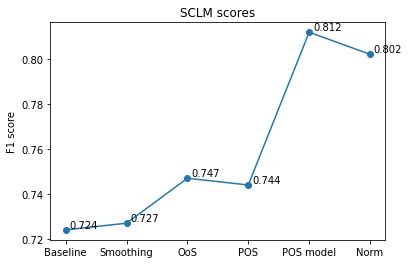

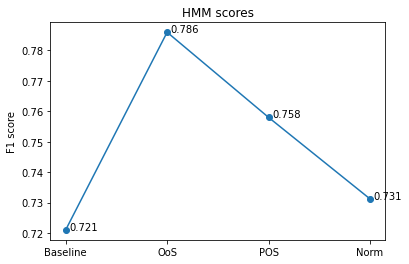

In [69]:
sclm =  [ 
    max(results, key=lambda x: x['f1'])['f1'],
    max(method_results, key=lambda x: x['f1'])['f1'],
    max(oos_results, key=lambda x: x['f1'])['f1'],
    max(with_POS_results, key=lambda x: x['f1'])['f1'],
    max(with_POS_models_results, key=lambda x: x['f1'])['f1'],
    max(normalization_results, key=lambda x: x['f1'])['f1']
]

hmm = [
    max(hmm_results, key=lambda x: x['f1'])['f1'],
    max(hmm_wo_oos_results, key=lambda x: x['f1'])['f1'],
    max(hmm_with_POS_results, key=lambda x: x['f1'])['f1'],
    max(hmm_norm_results, key=lambda x: x['f1'])['f1']
]

x_labels = ['Baseline', 'Smoothing', 'OoS', 'POS', 'POS model', 'Norm']
plt.plot(x_labels, sclm, '-o')

for x, y in zip(x_labels, sclm):
    label = "{:.3f}".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(18,2), ha='center')

plt.title('SCLM scores')
plt.ylabel('F1 score')
plt.show()


x_labels = ['Baseline', 'OoS', 'POS', 'Norm']
plt.plot(x_labels, hmm, '-o')

for x, y in zip(x_labels, hmm):
    label = "{:.3f}".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(18,0), ha='center')

plt.title('HMM scores')
plt.ylabel('F1 score')
plt.show()